In [1]:
import numpy as  np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os

In [2]:
# set up display options
plt.ioff()
np.set_printoptions(suppress=True)
np.random.seed(69)
# requires latex to be installed
# sudo apt install texlive-latex-base, texlive-latex-extra, dvipng
# warning: > 1GB install
font_dict = {
	'family':'sans-serif',
	'sans-serif':['Computer Modern'],
	'size': 28
}
mpl.rc('font',**font_dict)
mpl.rc('text',usetex=True)

In [3]:
# set up constants
chrm_len = 249250621
MAX_MUT = 13000.0
T = 4

In [4]:
# naive
naive_segs = [1000000 for i in range(0, chrm_len, 1000000)]
naive_segs = np.array(naive_segs)
naive_segs[-1] = chrm_len - np.sum(naive_segs[:-1])
assert np.sum(naive_segs) == chrm_len, np.sum(naive_segs)
naive_muts_t = np.random.uniform(low=0.0,high=MAX_MUT/T,size=[len(naive_segs),T])
naive_muts = np.sum(naive_muts_t, axis=1)
naive_probs_t = naive_muts_t / naive_muts.reshape(-1,1)
naive_ents = np.sum(- naive_probs_t * np.log2(naive_probs_t), axis=1)

In [5]:
# optimal 
opt_segs = 10**np.random.uniform(low=0.0,high=3.0,size=len(naive_segs))
opt_segs *= chrm_len / np.sum(opt_segs)
opt_segs = np.around(opt_segs).astype(np.int)
opt_segs[-1] = chrm_len - np.sum(opt_segs[:-1])
assert np.sum(opt_segs) == chrm_len, np.sum(opt_segs)
opt_muts_t = np.random.uniform(low=0.0,high=MAX_MUT/T,size=[len(opt_segs),T])
opt_muts = np.sum(opt_muts_t, axis=1)
opt_probs_t = opt_muts_t / opt_muts.reshape(-1,1)
opt_ents = np.sum(- opt_probs_t * np.log2(opt_probs_t), axis=1)

In [6]:
# put them together
both_segs = np.concatenate([naive_segs.reshape(-1,1),opt_segs.reshape(-1,1)], axis=1)
both_muts = np.concatenate([naive_muts.reshape(-1,1),opt_muts.reshape(-1,1)], axis=1)
both_ents = np.concatenate([naive_ents.reshape(-1,1),opt_ents.reshape(-1,1)], axis=1)

In [7]:
# set up the mut cmap
# the minimum and maximum are rounded to the nearest 1000
max_mut = np.ceil(np.max(both_muts) / 1000.0)*1000.0
min_mut = np.ceil(np.min(both_muts) / 1000.0)*1000.0
print(min_mut, max_mut)
mut_cmap = plt.get_cmap("Blues",1000)
mut_norm = mpl.colors.Normalize(vmin=min_mut,vmax=max_mut)
mut_sm = plt.cm.ScalarMappable(cmap=mut_cmap, norm=mut_norm)
both_muts_colors = mut_sm.to_rgba(both_muts)

1000.0 12000.0


In [8]:
# set up the ent cmap
max_ent = np.max(both_ents)
min_ent = np.min(both_ents)
print(min_ent, max_ent)
ent_cmap = plt.get_cmap("Reds",1000)
ent_norm = mpl.colors.Normalize(vmin=min_ent,vmax=max_ent)
ent_sm = plt.cm.ScalarMappable(cmap=ent_cmap, norm=ent_norm)
both_ents_colors = ent_sm.to_rgba(both_ents)

0.839825234919958 1.9979842237102632


In [9]:
# set up plot
fig, ax = plt.subplots(figsize=(10,10))
color1 = "green"
color2 = "#000000" # "black"
x_pos = [0.5,1.0,1.5,2.25,2.75,3.25]
width = 0.40

In [10]:
p_seg_init = ax.bar([x_pos[0],x_pos[3]], both_segs[0], width, color=color1)
p_mut_init = ax.bar([x_pos[1],x_pos[4]], both_segs[0], width, color=both_muts_colors[0])
p_ent_init = ax.bar([x_pos[2],x_pos[5]], both_segs[0], width, color=both_ents_colors[0])
for i in range(1,len(opt_segs)):
	seg_color = (color1 if i % 2 == 0 else color2)
	p_seg = ax.bar([x_pos[0],x_pos[3]], both_segs[i], width, color=seg_color, bottom=np.sum(both_segs[:i],axis=0))
	mut_colors = both_muts_colors[i]
	p_mut = ax.bar([x_pos[1],x_pos[4]], both_segs[i], width, color=mut_colors, bottom=np.sum(both_segs[:i],axis=0))
	ent_colors = both_ents_colors[i]
	p_ent = ax.bar([x_pos[2],x_pos[5]], both_segs[i], width, color=ent_colors, bottom=np.sum(both_segs[:i],axis=0))

In [11]:
# mutation colorbar
mut_sm.set_array([])
cbaxes = fig.add_axes([0.9, 0.15, 0.03, 0.3]) 
mut_cbar_bounds = np.linspace(min_mut,max_mut,1000).astype(np.int)
mut_cbar = plt.colorbar(ax=ax, mappable=mut_sm, cax=cbaxes, boundaries=mut_cbar_bounds)
mut_cbar.set_ticks(np.linspace(min_mut,max_mut,5).astype(np.int))
mut_cbar.set_ticklabels([f"{i}k" for i in np.linspace(min_mut/1000,max_mut/1000,5).astype(np.int)])
mut_cbar.set_label("Muts (count)",rotation=270,labelpad=30)

In [12]:
# entropy colorbar
ent_sm.set_array([])
cbaxes = fig.add_axes([0.9, 0.525, 0.03, 0.3])
ent_cbar_bounds = np.linspace(min_ent,max_ent,1000)
ent_cbar = plt.colorbar(ax=ax, mappable=ent_sm, cax=cbaxes, boundaries=ent_cbar_bounds)
ent_cbar.set_ticks(np.linspace(min_ent,max_ent,5))
ent_cbar.set_ticklabels(np.around(np.linspace(min_ent,max_ent,5),decimals=1))
ent_cbar.set_label("Entropy (bits)",rotation=270,labelpad=35)

In [13]:
ax.set_xticks([np.mean(x_pos[:3]),np.mean(x_pos[3:])])
ax.set_xticklabels(['Naive', 'Optimal'])
ax.set_xlim(0.0,x_pos[-1]+0.5)
ax.tick_params(axis='x', pad=10, length=0)
ax.set_ylim(0,chrm_len+1)
max_tick = np.around(chrm_len, decimals=-7)
ax.set_yticks(np.arange(0, max_tick+1, 20000000))
ax.set_ylim(0,max_tick)
# max_val = chrm_len
# ax.set_yticks(np.linspace(0,max_val,10))
ax.set_yticklabels(np.arange(0, int(np.floor(max_tick / 1000000))+1, 20))
ax.set_ylabel("Position (Mb)",labelpad=20)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)

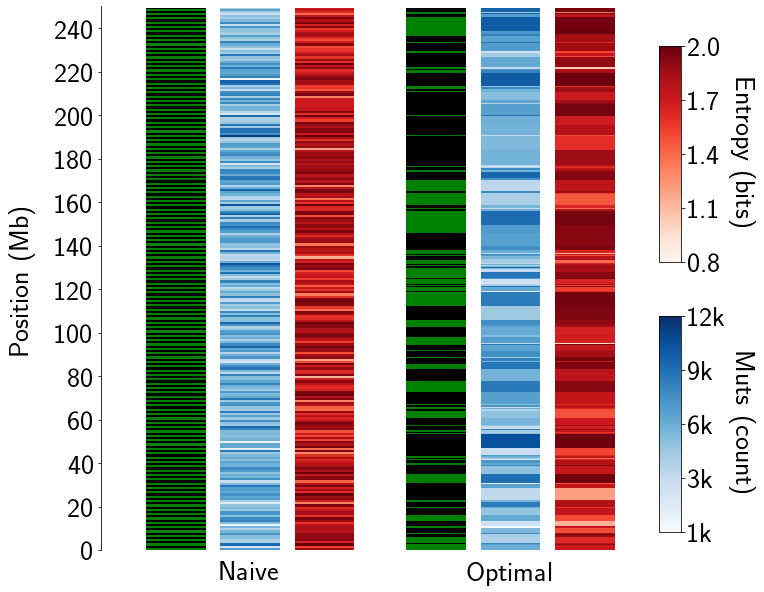

In [14]:
# bbox = mpl.transforms.Bbox([[-2,-2],[12,12]])
# fig.subplots_adjust(right=1.15)
# fig.tight_layout(rect=[0,0,1.2,1])
plt.savefig("poster/quick_test.png",bbox_inches="tight",format="png")
plt.show()